# Анализ сайта «СберАвтоподписка» и построение модели предсказания целевых действий (v2)

## **Цель проекта**

### Создать модель машинного обучения, предсказывающую вероятность совершения пользователем целевого действия на сайте «СберАвтоподписка», для оценки эффективности каналов трафика, адаптации рекламных кампаний и улучшения UX. Сравнить несколько подходов к моделированию.
#
## **План работы:**
### 1. Загрузка и подготовка данных
### 2. Разведочный анализ данных (EDA)
### 3. Фиче-инжиниринг
### 4. Построение и оценка ML-моделей (Baseline, LogReg, LGBM, CatBoost)
### 5. Выводы и интерпретация

### 0. Настройка окружения и импорты

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import gc
import warnings

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Настройки визуализации
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.max_columns = 100 # Показывать больше колонок
pd.options.display.max_rows = 100 # Показывать больше строк

In [ ]:
# Добавляем путь к нашим модулям в src/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Импортируем наши модули
import importlib
from src import data_processing
importlib.reload(data_processing)
from src import data_processing as dp


from src import feature_engineering
importlib.reload(feature_engineering)
from src import feature_engineering as fe
from src import training
importlib.reload(training)
from src import training as tr

### 1. Загрузка и подготовка данных

In [ ]:
# Указываем пути к данным
DATA_DIR = '../data/'
SESSIONS_PATH = os.path.join(DATA_DIR, 'ga_sessions.pkl')
HITS_PATH = os.path.join(DATA_DIR, 'ga_hits.pkl')

#### 1.1 Загрузка данных
Загружаем сессии и хиты (хиты нужны для определения target и агрегации фичей)

In [ ]:
df_sessions, df_hits = dp.load_data(SESSIONS_PATH, HITS_PATH, load_hits=True)

# Проверяем загруженные данные
if df_sessions is not None:
    print("\nSessions DataFrame Info:")
    df_sessions.info(memory_usage='deep')
    display(df_sessions.head())
    print(f"Session columns: {df_sessions.columns.tolist()}") # Проверяем колонки

if df_hits is not None:
    print("\nHits DataFrame Info:")
    df_hits.info(memory_usage='deep')
    display(df_hits.head())
    print(f"Hits columns: {df_hits.columns.tolist()}") # Проверяем колонки
else:
    print("\nWarning: Hits data could not be loaded. Target definition and feature aggregation might fail.")

Loading sessions data from: ../data/ga_sessions.pkl
-> Sessions loaded successfully: (1860042, 18)
Loading hits data from: ../data/ga_hits.pkl (minimal columns)
-> Hits loaded and filtered successfully: (15726470, 6)

Sessions DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  objec

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


Session columns: ['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

Hits DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   session_id     object 
 1   hit_number     int64  
 2   hit_time       float64
 3   hit_page_path  object 
 4   event_action   object 
 5   hit_type       object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.2 GB


,session_id,hit_number,hit_time,hit_page_path,event_action,hit_type
0,5639623078712724064.1640254056.1640254056,30,597864.0,sberauto.com/cars?utm_source_initial=google&ut...,quiz_show,event
1,7750352294969115059.1640271109.1640271109,41,597331.0,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz_show,event
2,885342191847998240.1640235807.1640235807,49,796252.0,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz_show,event
3,142526202120934167.1640211014.1640211014,46,934292.0,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz_show,event
4,3450086108837475701.1640265078.1640265078,79,768741.0,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz_show,event


Hits columns: ['session_id', 'hit_number', 'hit_time', 'hit_page_path', 'event_action', 'hit_type']


### 1.2 Определение целевой переменной (Target)

In [ ]:
# Создаем колонку 'target' в df_sessions
if df_hits is not None and 'event_action' in df_hits.columns:
    df_sessions = dp.define_target(df_sessions, df_hits)
else:
    print("Skipping target definition as hits data or 'event_action' column is missing.")
    df_sessions['target'] = 0 # Устанавливаем дефолтное значение

Defining target based on 21 event_action(s)...
Found 62501 sessions with at least one target action.
Target variable distribution:
target
0    0.9666
1    0.0334
Name: proportion, dtype: float64
Note: Target class distribution is imbalanced: 3.34% positive class.



Target variable distribution:
         Counts  Percentage
target                     
0       1797900   96.659108
1         62142    3.340892


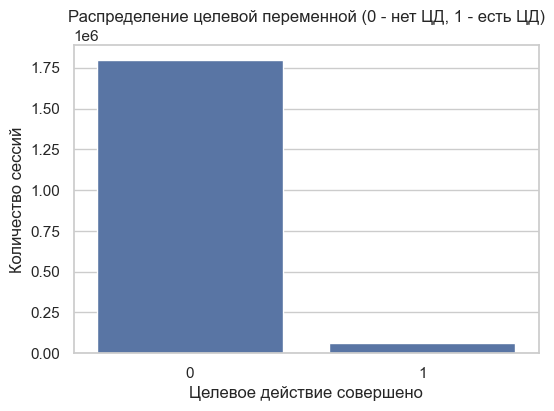

In [ ]:
if 'target' in df_sessions.columns:
    print("\nTarget variable distribution:")
    target_counts = df_sessions['target'].value_counts()
    target_perc = df_sessions['target'].value_counts(normalize=True) * 100
    print(pd.concat([target_counts, target_perc], axis=1, keys=['Counts', 'Percentage']))

    # Визуализация дисбаланса
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df_sessions)
    plt.title('Распределение целевой переменной (0 - нет ЦД, 1 - есть ЦД)')
    plt.xlabel('Целевое действие совершено')
    plt.ylabel('Количество сессий')
    plt.show()
else:
    print("Target variable was not created.")

### 1.3 Базовая очистка данных сессий

In [ ]:
df_sessions_cleaned = dp.basic_cleaning(df_sessions.copy()) # Работаем с копией

# Проверяем результат очистки
print("\nSessions DataFrame Info after cleaning:")
df_sessions_cleaned.info(memory_usage='deep')
display(df_sessions_cleaned.head())
print("\nMissing values after cleaning (should be low or zero):")
missing_vals = df_sessions_cleaned.isnull().sum()
display(missing_vals[missing_vals > 0])

Starting basic data cleaning...
Basic cleaning finished. Resulting shape: (1860042, 18)

Sessions DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_number              int32         
 3   utm_source                category      
 4   utm_medium                category      
 5   utm_campaign              category      
 6   utm_adcontent             object        
 7   utm_keyword               category      
 8   device_category           category      
 9   device_os                 category      
 10  device_brand              category      
 11  device_model              category      
 12  device_screen_resolution  object        
 13  device_browser            category      
 14  geo_country      

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_datetime
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,unknown,360x720,Chrome,Russia,Zlatoust,0,2021-11-24 14:36:32
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,unknown,385x854,Samsung Internet,Russia,Moscow,0,2021-11-14 08:21:30
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,unknown,360x720,Chrome,Russia,Krasnoyarsk,0,2021-12-28 02:42:06
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,unknown,NOBKLgtuvqYWkXQHeYWM,unknown,mobile,None,Xiaomi,unknown,393x786,Chrome,Russia,Moscow,0,2021-05-29 05:00:00
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,unknown,NaN,unknown,mobile,None,Xiaomi,unknown,393x786,Chrome,Russia,Moscow,0,2021-05-29 05:00:00



Missing values after cleaning (should be low or zero):


utm_adcontent    335615
dtype: int64

In [ ]:
if 'utm_adcontent' in df_sessions_cleaned.columns:
    nan_mask = df_sessions_cleaned['utm_adcontent'].isnull()
    if nan_mask.any():
        print(f"Found {nan_mask.sum()} actual NaN values in 'utm_adcontent'. Replacing with 'unknown'.")
        df_sessions_cleaned.loc[nan_mask, 'utm_adcontent'] = 'unknown'

    if pd.api.types.is_categorical_dtype(df_sessions_cleaned['utm_adcontent']):
        current_categories = df_sessions_cleaned['utm_adcontent'].cat.categories.tolist()
        if 'unknown' not in current_categories:
            print("Adding 'unknown' to categories of 'utm_adcontent'.")
            df_sessions_cleaned['utm_adcontent'] = df_sessions_cleaned['utm_adcontent'].cat.add_categories(['unknown'])

        if df_sessions_cleaned['utm_adcontent'].isnull().any():
             print("Filling remaining NaNs in categorical 'utm_adcontent' with 'unknown'.")
             df_sessions_cleaned['utm_adcontent'] = df_sessions_cleaned['utm_adcontent'].fillna('unknown')

    elif df_sessions_cleaned['utm_adcontent'].isnull().any():
         print("Filling NaNs in non-categorical 'utm_adcontent' with 'unknown'.")
         df_sessions_cleaned['utm_adcontent'].fillna('unknown', inplace=True)
    values_to_replace_extra = ['', '(not set)', '(none)', '(not provided)', 'unknown.unknown', '<NA>', 'nan']
    df_sessions_cleaned['utm_adcontent'] = df_sessions_cleaned['utm_adcontent'].astype(str).replace(values_to_replace_extra, 'unknown')
    print("Converting 'utm_adcontent' back to category type.")
    df_sessions_cleaned['utm_adcontent'] = df_sessions_cleaned['utm_adcontent'].astype('category')
    print("\nMissing values in 'utm_adcontent' after explicit handling:")
    print(df_sessions_cleaned['utm_adcontent'].isnull().sum())
    print("\nValue counts for 'utm_adcontent' (including 'unknown'):")
    print(df_sessions_cleaned['utm_adcontent'].value_counts().head())

else:
    print("Column 'utm_adcontent' not found in df_sessions_cleaned.")

Found 335615 actual NaN values in 'utm_adcontent'. Replacing with 'unknown'.


C:\Users\aak25\AppData\Local\Temp\ipykernel_2292\2693061540.py:12: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



Converting 'utm_adcontent' back to category type.

Missing values in 'utm_adcontent' after explicit handling:
0

Value counts for 'utm_adcontent' (including 'unknown'):
utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
unknown                  335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
Name: count, dtype: int64


### 1.4 Классификация трафика

In [ ]:
df_sessions_cleaned = dp.classify_traffic(df_sessions_cleaned)
display(df_sessions_cleaned[['utm_source', 'utm_medium', 'traffic_type']].sample(5))

Classifying traffic types based on 'utm_medium'...
Traffic types classified. Distribution:
traffic_type
paid       0.871
organic    0.116
social     0.013
Name: proportion, dtype: float64


,utm_source,utm_medium,traffic_type
1419194,ZpYIoDJMcFzVoPFsHGJL,banner,paid
1371652,kjsLglQLzykiRbcDiGcD,cpc,paid
481287,MvfHsxITijuriZxsqZqt,cpm,paid
891661,zwpKjjsMoRVCdipntaHt,referral,organic
387224,ZpYIoDJMcFzVoPFsHGJL,banner,paid


## 2. Разведочный анализ данных (EDA)

### **Цель EDA:** понять структуру данных, распределения признаков, выявить закономерности и аномалии, найти связи между признаками и целевой переменной.

Работаем с очищенным датасетом `df_sessions_cleaned`.

### 2.1 Анализ ключевых категориальных признаков


--- Анализ признака: utm_source (Seaborn) ---


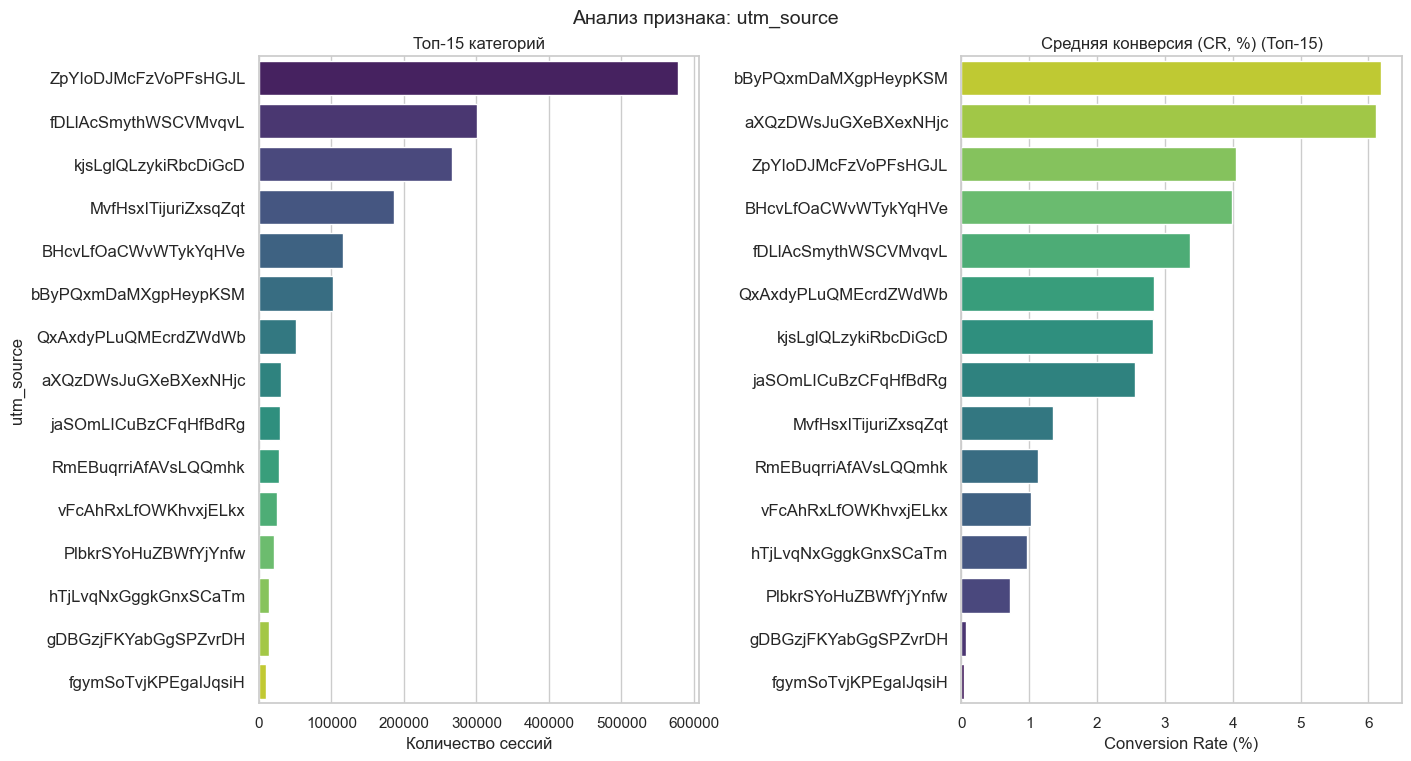

Количество уникальных значений в 'utm_source': 294
Топ-15 категорий по частоте:
utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
Name: count, dtype: int64

Топ-15 категорий по средней конверсии (из показанных на графике частоты):
utm_source
bByPQxmDaMXgpHeypKSM    6.183
aXQzDWsJuGXeBXexNHjc    6.118
ZpYIoDJMcFzVoPFsHGJL    4.042
BHcvLfOaCWvWTykYqHVe    3.995
fDLlAcSmythWSCVMvqvL    3.369
QxAxdyPLuQMEcrdZWdWb    2.840
kjsLglQLzykiRbcDiGcD    2.821
jaSOmLICuBzCFqHfBdRg    2.558
MvfHsxITijuriZxsqZqt    1.355
RmEBuqrriAfAVsLQQmhk    1.133
vFcAhRxLfOWKhvxjELkx    1.020
hT

In [ ]:
def plot_top_categories_seaborn(df, column, target_col='target', top_n=15):
    """
    Строит график топ-N категорий и их средний CR с помощью Matplotlib/Seaborn,
    с улучшенной обработкой меток оси Y.
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in DataFrame. Skipping plot.")
        return

    print(f"\n--- Анализ признака: {column} (Seaborn) ---")

    valid_categories_counts = df[column].astype(str).value_counts()
    top_categories_idx = valid_categories_counts.nlargest(top_n).index

    plot_data = df[df[column].isin(top_categories_idx)].copy()
    plot_data[column] = plot_data[column].astype(str)


    fig, axes = plt.subplots(1, 2, figsize=(14, max(7, top_n * 0.5)), constrained_layout=True)
    fig.suptitle(f'Анализ признака: {column}', fontsize=14) # Общий заголовок

    sns.countplot(ax=axes[0], y=column, data=plot_data, order=top_categories_idx, palette='viridis')
    axes[0].set_title(f'Топ-{top_n} категорий')
    axes[0].set_xlabel('Количество сессий')
    axes[0].set_ylabel(column) # Оставляем подпись оси Y

    if target_col in df.columns:
        # Считаем CR только для топ-N категорий (из plot_data)
        # observed=False важно для категориальных типов
        cr_by_cat = plot_data.groupby(column, observed=False)[target_col].mean().sort_values(ascending=False)
        cr_by_cat_perc = cr_by_cat * 100 # В процентах

        sns.barplot(ax=axes[1], y=cr_by_cat_perc.index, x=cr_by_cat_perc.values, palette='viridis_r')
        axes[1].set_title(f'Средняя конверсия (CR, %) (Топ-{top_n})')
        axes[1].set_xlabel('Conversion Rate (%)')
        axes[1].set_ylabel('') # Убираем дублирующуюся подпись оси Y
    else:
        # Если нет target_col, можно скрыть второй график
        axes[1].set_visible(False)

    tick_fontsize = 'medium' # Default
    if top_n > 35:
        tick_fontsize = 'xx-small'
    elif top_n > 25:
        tick_fontsize = 'x-small'
    elif top_n > 18:
        tick_fontsize = 'small'

    axes[0].tick_params(axis='y', labelsize=tick_fontsize)
    if target_col in df.columns and axes[1].get_visible():
        axes[1].tick_params(axis='y', labelsize=tick_fontsize)

    plt.show()

    print(f"Количество уникальных значений в '{column}': {df[column].nunique()}")
    print(f"Топ-{top_n} категорий по частоте:")
    # Используем исходный подсчет valid_categories_counts
    print(valid_categories_counts.head(top_n))

    if target_col in df.columns:
         print(f"\nТоп-{top_n} категорий по средней конверсии (из показанных на графике частоты):")
         if 'cr_by_cat_perc' in locals(): # Проверяем, была ли переменная создана
              print(cr_by_cat_perc.round(3))
         else: # Если target_col не было, считаем CR для всех
              print("(Пересчет CR для всех категорий)")
              all_cr_by_cat = df.groupby(column, observed=False)[target_col].mean().sort_values(ascending=False)
              print((all_cr_by_cat.head(top_n) * 100).round(3))

# Анализируем основные категориальные признаки, включая utm_adcontent
plot_top_categories_seaborn(df_sessions_cleaned, 'utm_source')


--- Анализ признака: utm_medium (Seaborn) ---


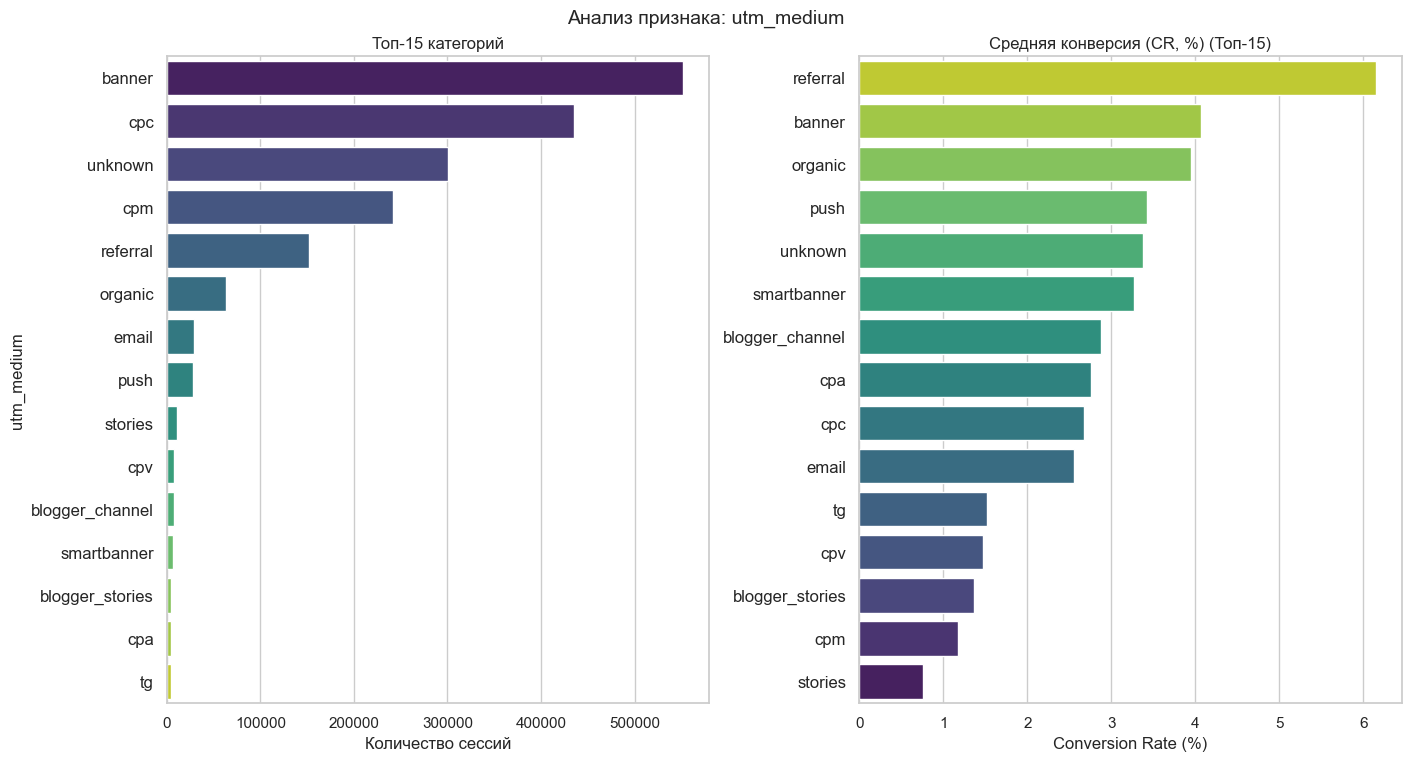

Количество уникальных значений в 'utm_medium': 55
Топ-15 категорий по частоте:
utm_medium
banner             552272
cpc                434794
unknown            301055
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
Name: count, dtype: int64

Топ-15 категорий по средней конверсии (из показанных на графике частоты):
utm_medium
referral           6.150
banner             4.071
organic            3.950
push               3.421
unknown            3.375
smartbanner        3.268
blogger_channel    2.882
cpa                2.758
cpc                2.681
email              2.555
tg                 1.521
cpv                1.471
blogger_stories    1.368
cpm                1.181
stories            0.756
Name: target, dtype: float64


In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'utm_medium')


--- Анализ признака: utm_campaign (Seaborn) ---


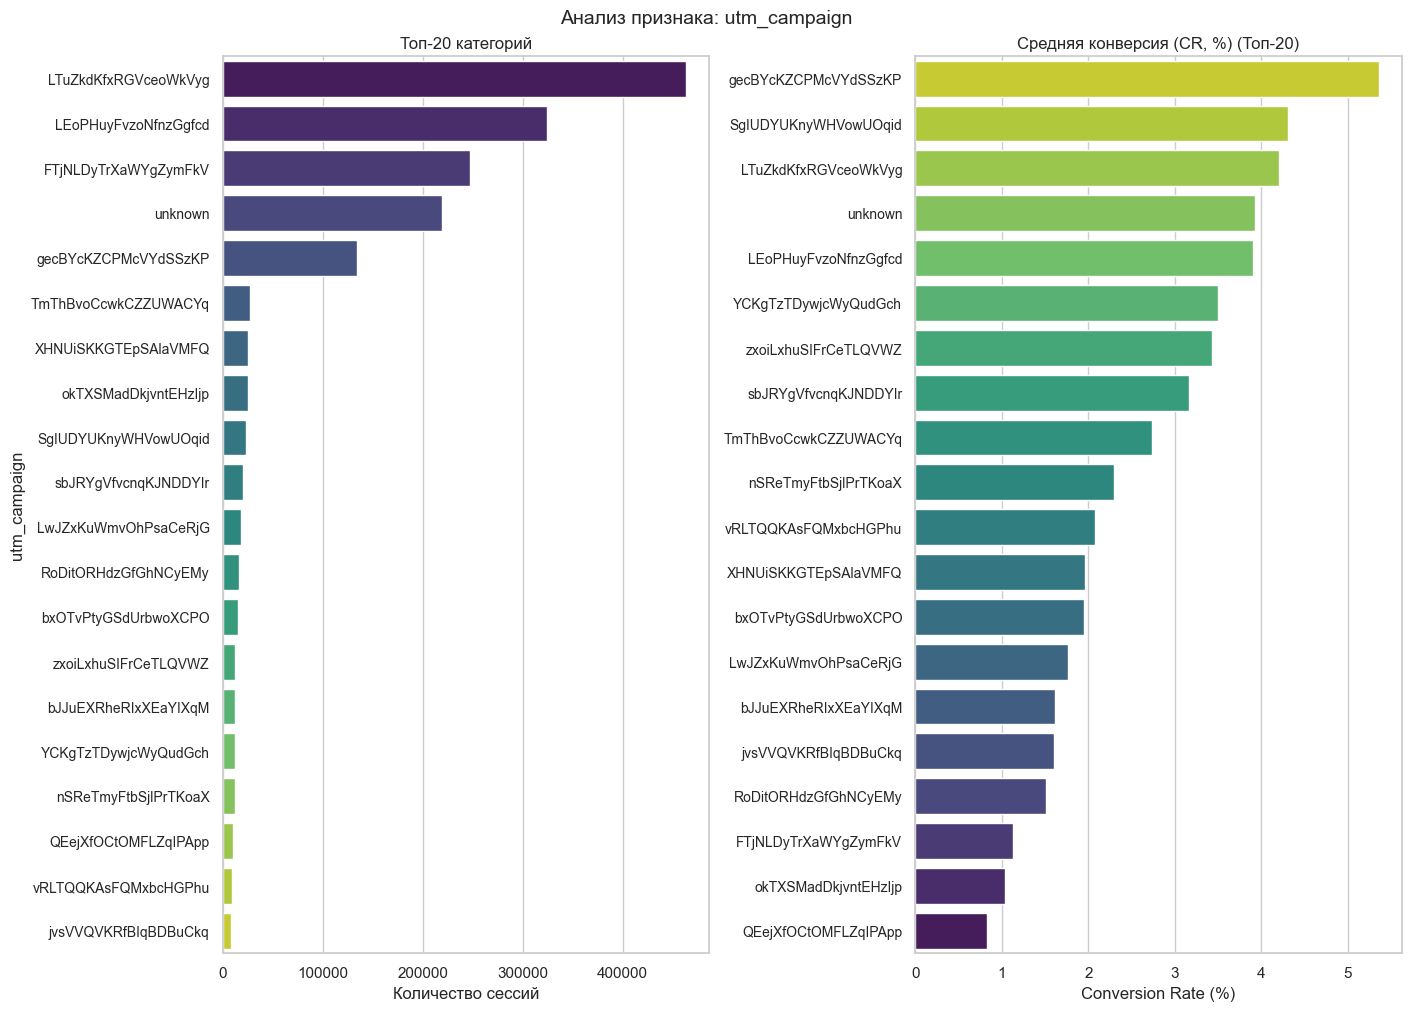

Количество уникальных значений в 'utm_campaign': 413
Топ-20 категорий по частоте:
utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
unknown                 219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
YCKgTzTDywjcWyQudGch     12041
nSReTmyFtbSjlPrTKoaX     11611
QEejXfOCtOMFLZqIPApp     10172
vRLTQQKAsFQMxbcHGPhu      9461
jvsVVQVKRfBIqBDBuCkq      7950
Name: count, dtype: int64

Топ-20 категорий по средней конверсии (из показанных на графике частоты):
utm_campaign
gecBYcKZCPMcVYdSSzKP    5.356
SgIUDYUKnyWHVowUOqid    4.308
LTuZkdKfxRGVceoWkVyg    4.208
unknown                 3.926
LEoPHuyFvzoNfnzGgfcd    3.903
YCKgTzTDywjcWyQudGch 

In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'utm_campaign', top_n=20)


--- Анализ признака: utm_adcontent (Seaborn) ---


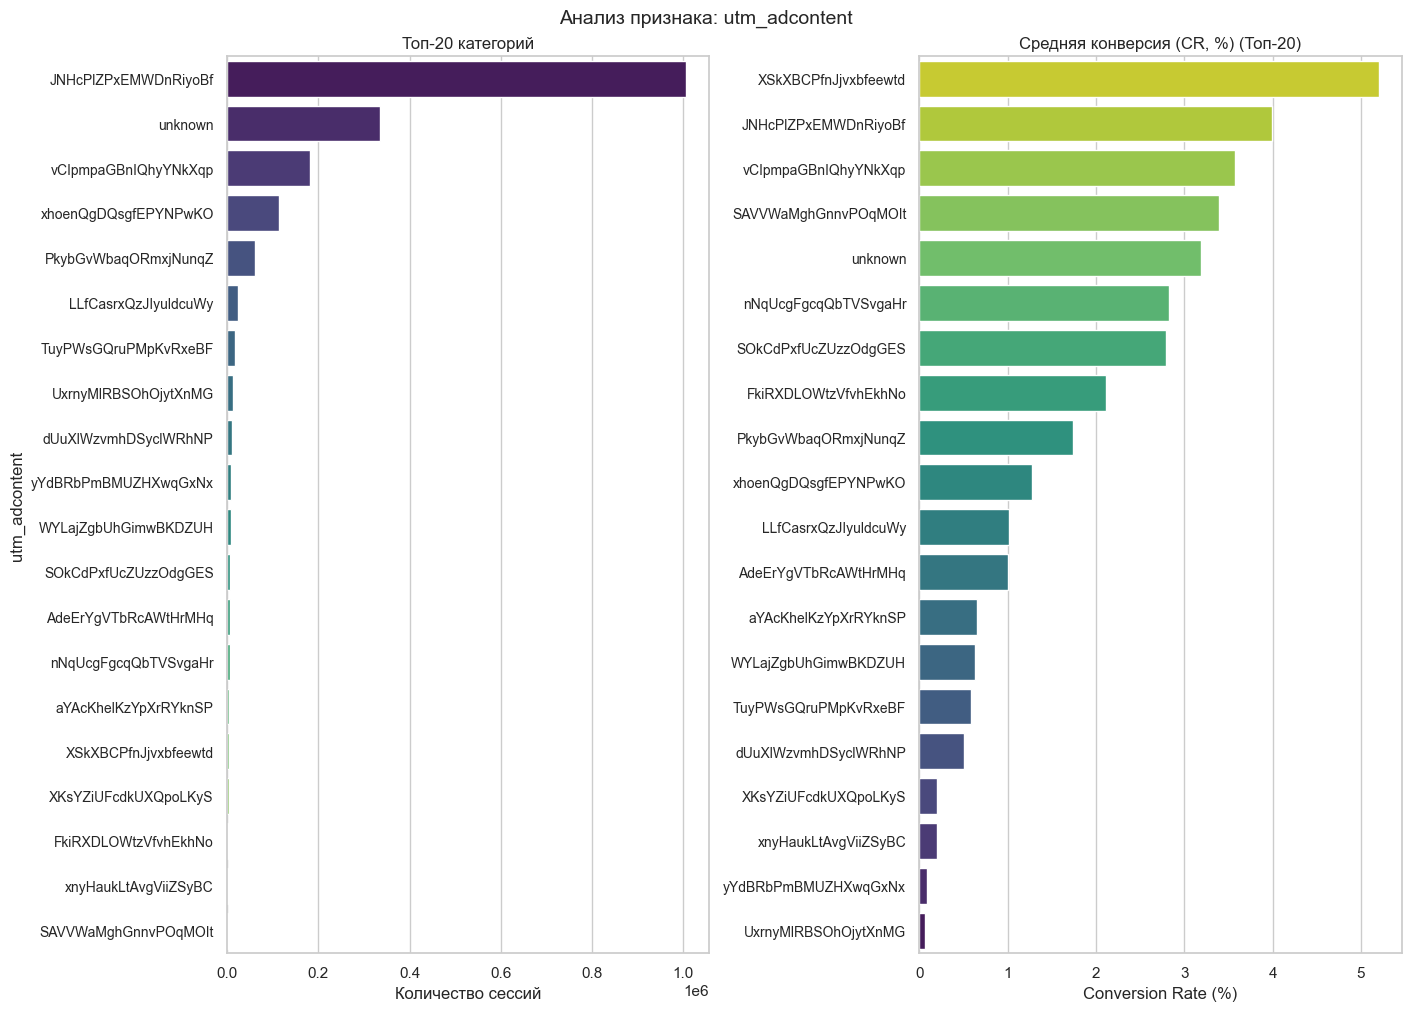

Количество уникальных значений в 'utm_adcontent': 287
Топ-20 категорий по частоте:
utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
unknown                  335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
XSkXBCPfnJjvxbfeewtd       4383
XKsYZiUFcdkUXQpoLKyS       4112
FkiRXDLOWtzVfvhEkhNo       2841
xnyHaukLtAvgViiZSyBC       2582
SAVVWaMghGnnvPOqMOIt       2501
Name: count, dtype: int64

Топ-20 категорий по средней конверсии (из показанных на графике частоты):
utm_adcontent
XSkXBCPfnJjvxbfeewtd    5.202
JNHcPlZPxEMWDnRiyoBf    3.997
vCIpmpaGBnIQhyYNkXqp    3.572
SAVVWaMghGnnvPOqMOIt    3.399
unknown                 3.19

In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'utm_adcontent', top_n=20) # Добавили adcontent


--- Анализ признака: device_category (Seaborn) ---


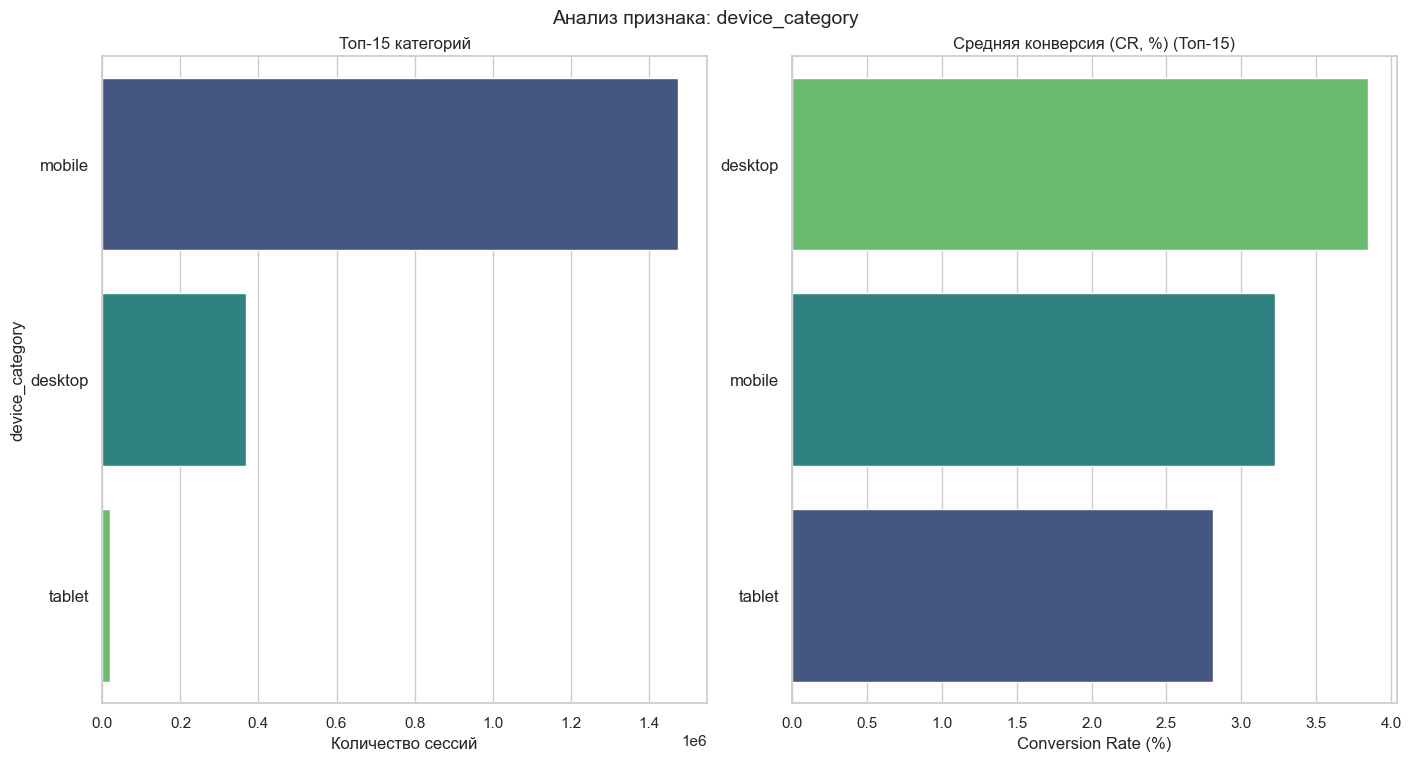

Количество уникальных значений в 'device_category': 3
Топ-15 категорий по частоте:
device_category
mobile     1474871
desktop     366863
tablet       18308
Name: count, dtype: int64

Топ-15 категорий по средней конверсии (из показанных на графике частоты):
device_category
desktop    3.844
mobile     3.222
tablet     2.813
Name: target, dtype: float64


In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'device_category')


--- Анализ признака: device_os (Seaborn) ---


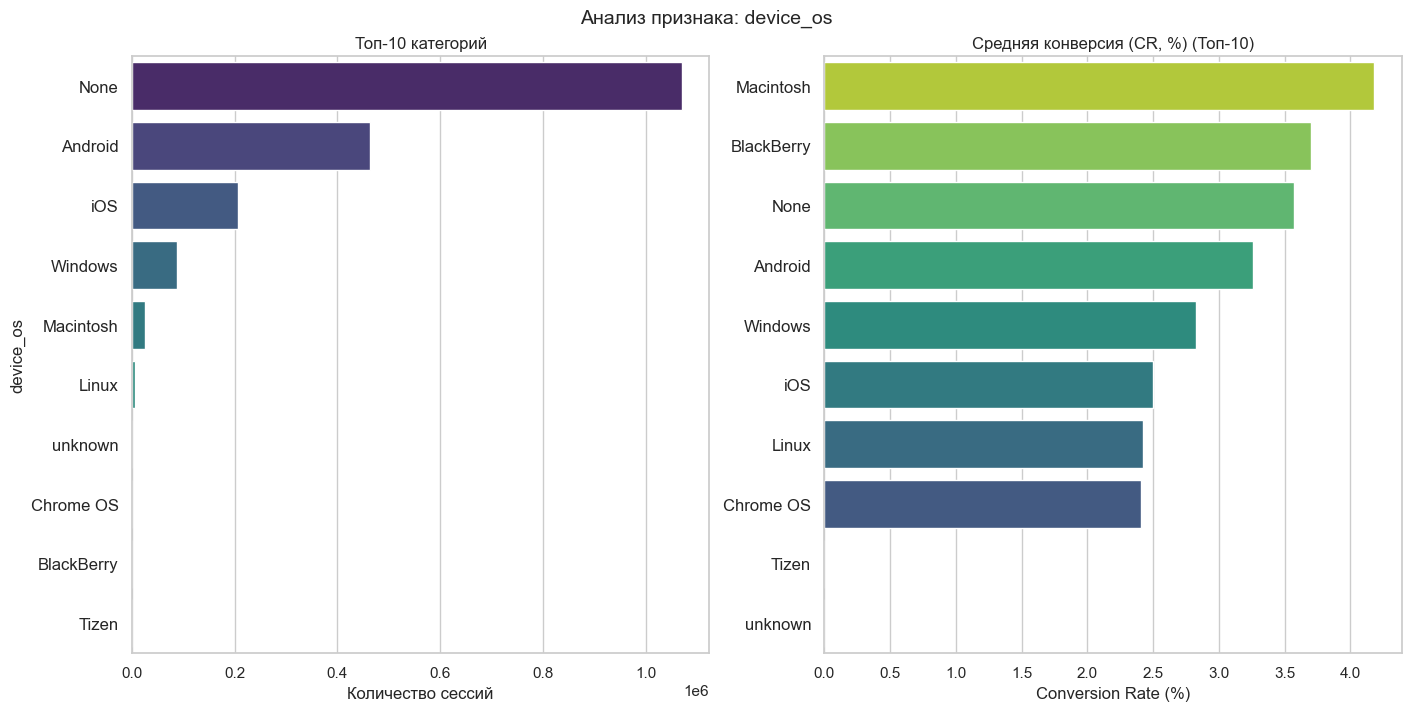

Количество уникальных значений в 'device_os': 14
Топ-10 категорий по частоте:
device_os
None          1070138
Android        464054
iOS            207104
Windows         88307
Macintosh       24824
Linux            5120
unknown           364
Chrome OS          83
BlackBerry         27
Tizen               7
Name: count, dtype: int64

Топ-10 категорий по средней конверсии (из показанных на графике частоты):
device_os
Macintosh     4.181
BlackBerry    3.704
None          3.570
Android       3.256
Windows       2.823
iOS           2.497
Linux         2.422
Chrome OS     2.410
Tizen         0.000
unknown       0.000
Name: target, dtype: float64


In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'device_os', top_n=10)


--- Анализ признака: device_browser (Seaborn) ---


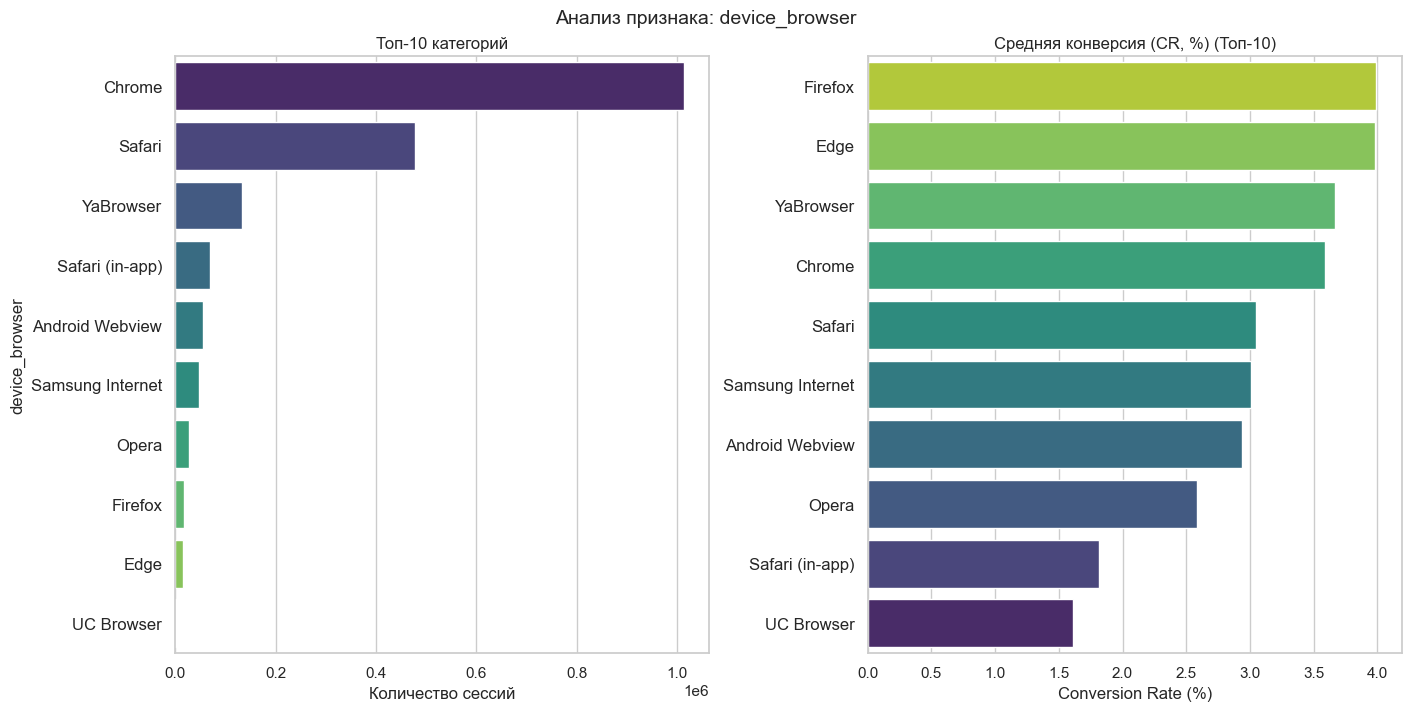

Количество уникальных значений в 'device_browser': 57
Топ-10 категорий по частоте:
device_browser
Chrome              1013436
Safari               478562
YaBrowser            133311
Safari (in-app)       69912
Android Webview       55369
Samsung Internet      47309
Opera                 26817
Firefox               16588
Edge                  16065
UC Browser              871
Name: count, dtype: int64

Топ-10 категорий по средней конверсии (из показанных на графике частоты):
device_browser
Firefox             3.991
Edge                3.984
YaBrowser           3.665
Chrome              3.588
Safari              3.044
Samsung Internet    3.006
Android Webview     2.935
Opera               2.584
Safari (in-app)     1.812
UC Browser          1.607
Name: target, dtype: float64


In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'device_browser', top_n=10)


--- Анализ признака: geo_city (Seaborn) ---


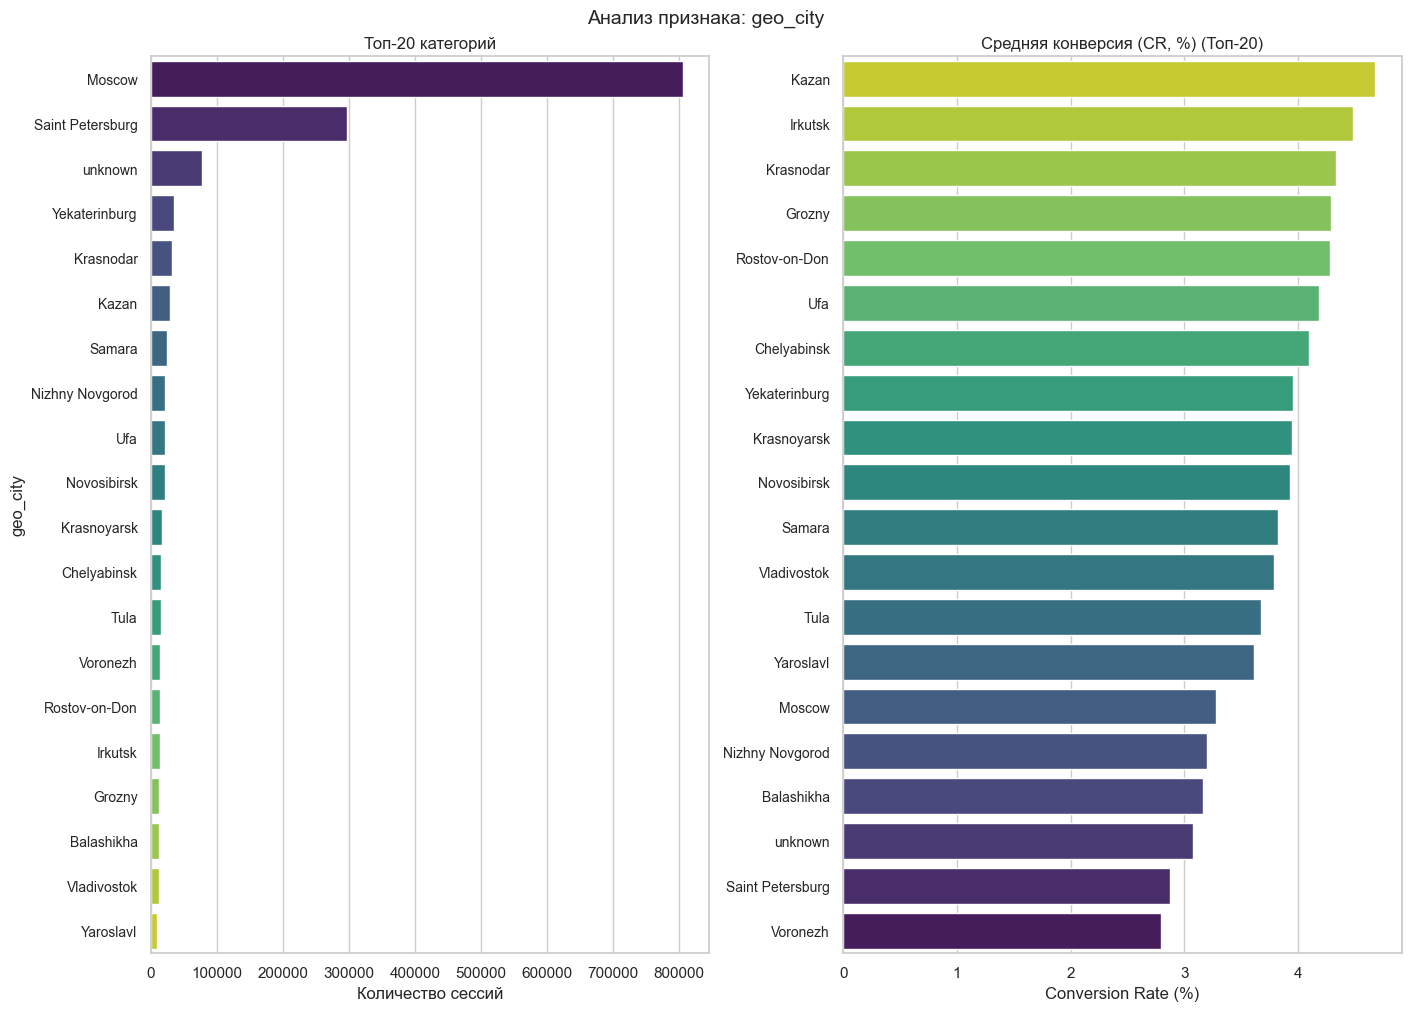

Количество уникальных значений в 'geo_city': 2548
Топ-20 категорий по частоте:
geo_city
Moscow              805329
Saint Petersburg    296788
unknown              78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Irkutsk              13532
Grozny               12742
Balashikha           12679
Vladivostok          12325
Yaroslavl             9833
Name: count, dtype: int64

Топ-20 категорий по средней конверсии (из показанных на графике частоты):
geo_city
Kazan               4.676
Irkutsk             4.486
Krasnodar           4.330
Grozny              4.293
Rostov-on-Don       4.278
Ufa                 4.184
Chelyabinsk         4.094
Yekaterinburg       3.951
Krasnoyarsk         3.946
Novosibirsk         3.927
Sa

In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'geo_city', top_n=20)


--- Анализ признака: traffic_type (Seaborn) ---


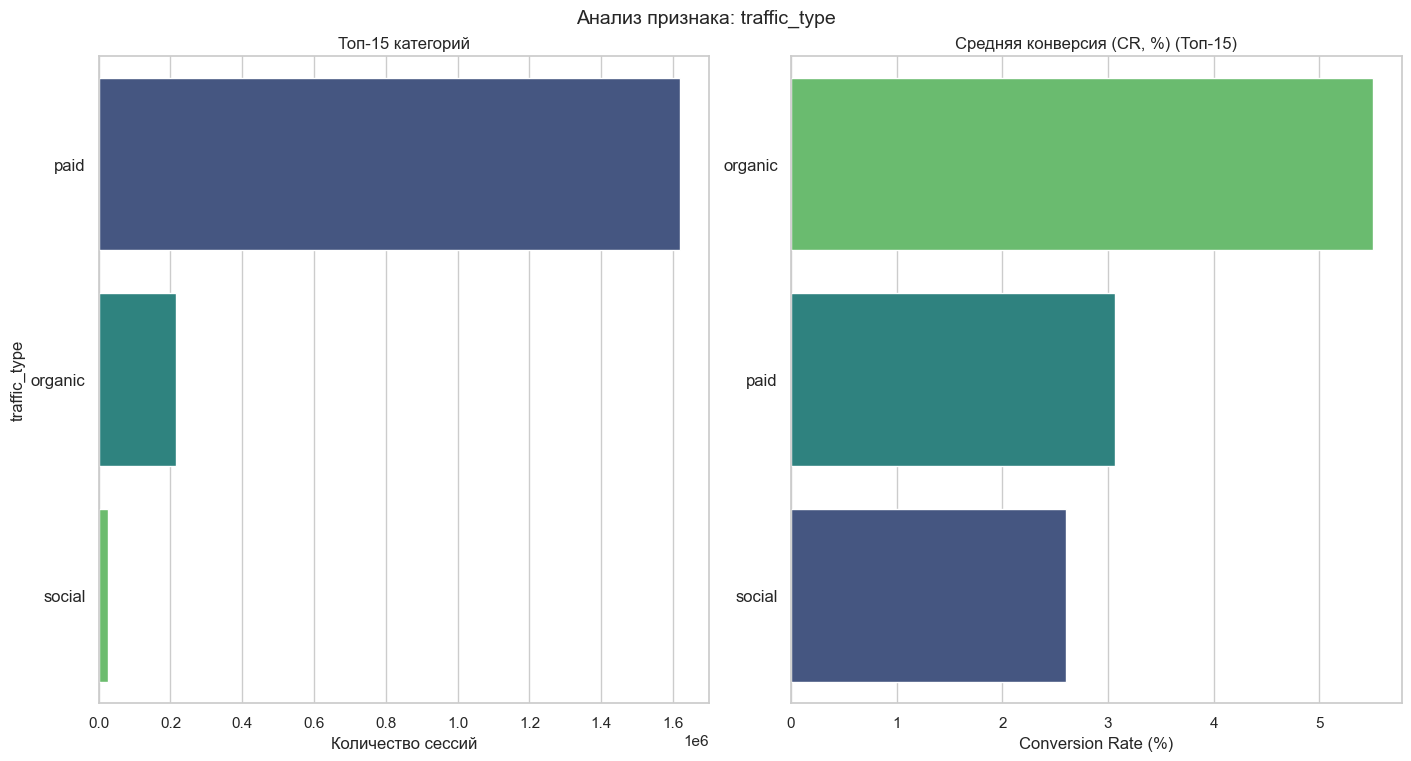

Количество уникальных значений в 'traffic_type': 3
Топ-15 категорий по частоте:
traffic_type
paid       1620055
organic     215084
social       24903
Name: count, dtype: int64

Топ-15 категорий по средней конверсии (из показанных на графике частоты):
traffic_type
organic    5.505
paid       3.065
social     2.602
Name: target, dtype: float64


In [ ]:
plot_top_categories_seaborn(df_sessions_cleaned, 'traffic_type')

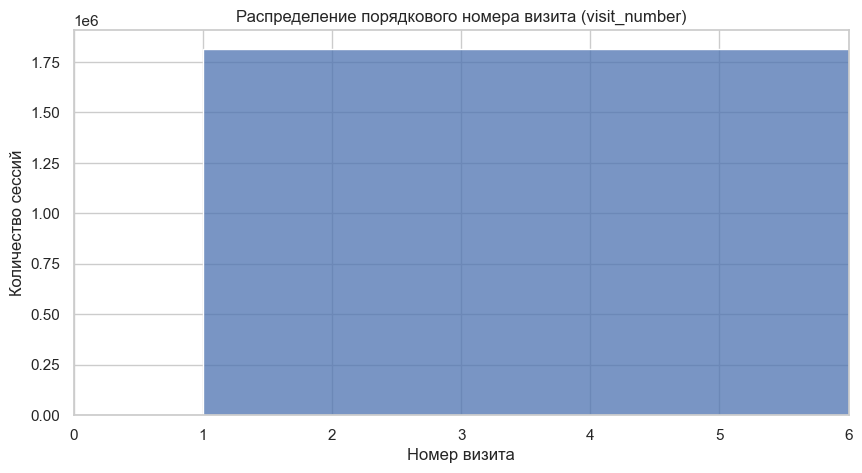

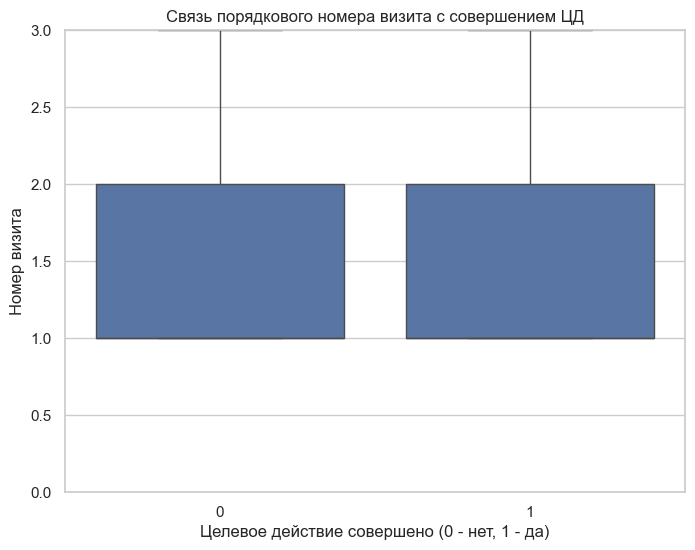


Статистика visit_number для каждой группы:
            count      mean        std  min  25%  50%  75%    max
target                                                           
0       1797900.0  2.662955  11.223900  1.0  1.0  1.0  2.0  564.0
1         62142.0  4.155064  23.268351  1.0  1.0  1.0  2.0  562.0


In [ ]:
if 'visit_number' in df_sessions_cleaned.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_sessions_cleaned['visit_number'], bins=50, kde=False)
    plt.title('Распределение порядкового номера визита (visit_number)')
    plt.xlabel('Номер визита')
    plt.ylabel('Количество сессий')
    plt.xlim(0, df_sessions_cleaned['visit_number'].quantile(0.95))
    plt.show()

    if 'target' in df_sessions_cleaned.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='target', y='visit_number', data=df_sessions_cleaned)
        plt.title('Связь порядкового номера визита с совершением ЦД')
        plt.xlabel('Целевое действие совершено (0 - нет, 1 - да)')
        plt.ylabel('Номер визита')
        plt.ylim(0, df_sessions_cleaned['visit_number'].quantile(0.9))
        plt.show()

        print("\nСтатистика visit_number для каждой группы:")
        print(df_sessions_cleaned.groupby('target')['visit_number'].describe())
else:
    print("Column 'visit_number' not found.")

### **Выводы по EDA:**

1.  **Низкая общая конверсия:** только **~3.34%** визитов завершаются ключевым целевым действием (заявка, звонок, чат). Это типично для многих сайтов и ставит перед нами реалистичную задачу по выявлению факторов, влияющих на эту относительно редкую конверсию.

2.  **Эффективность типов трафика.**
    *   **Объем:** платный трафик (`paid`) доминирует по объему, значительно опережая органический (`organic`) и социальный (`social`).
    *   **Конверсия:** **органический трафик (`organic`) теперь самый конверсионный (CR 5.5%)!** Это важное открытие. Платный трафик (`paid`) конвертируется хуже (3.1%), а социальный (`social`) - еще хуже (2.6%).
    *   **Вывод:** необходимо пересмотреть стратегию. Органический трафик приводит наиболее заинтересованную аудиторию. Эффективность платного трафика нужно повышать, возможно, за счет оптимизации кампаний или таргетинга. Социальные сети в текущем виде почти не приносят конверсий.

3.  **География.**
    *   **Объем:** москва и Санкт-Петербург лидируют, но много трафика и из других регионов.
    *   **Конверсия:** наблюдается **заметная разница** в CR по городам. Лидируют **Казань (4.7%), Иркутск (4.5%), Краснодар (4.3%)**. Крупнейшие по объему Москва (3.3%) и Санкт-Петербург (2.9%) показывают CR **ниже среднего или на уровне среднего**. Воронеж (2.8%) остается одним из аутсайдеров. `unknown` города (3.1%) конвертируются средне.
    *   **Вывод:** эффективность привлечения и конверсии **сильно зависит от региона**. Стоит изучить причины высокой конверсии в Казани, Иркутске, Краснодаре и низкой в СПб, Воронеже. Возможно, дело в региональных кампаниях или специфике спроса.

4.  **Платформа пользователя.**
    *   **Объем:** мобильные устройства доминируют, Chrome и Safari - основные браузеры, много ОС `None`.
    *   **Конверсия.**
        *   **Устройства:** **десктоп (`desktop`) теперь конвертируется лучше (3.8%)**, чем мобильные (`mobile` 3.2%) и планшеты (`tablet` 2.8%).
        *   **Браузеры:** лидерами по CR стали **Firefox (4.0%) и Edge (4.0%)**, опережая Chrome (3.6%) и YaBrowser (3.7%). Safari (3.0%) и мобильные браузеры (Samsung Internet 3.0%, Android Webview 2.9%, Safari (in-app) 1.8%) показывают **более низкую конверсию**.
        *   **ОС:** **macintosh (4.2%)** лидирует. `None` (3.6%) и Android (3.3%) показывают средний CR. Windows (2.8%) и **iOS (2.5%)** конвертируются **хуже**. Tizen и unknown имеют нулевую конверсию (вероятно, мало данных или только нецелевые визиты).
    *   **Вывод:** пользователи **десктопов** более склонны к конверсии. Существуют **проблемы с конверсией на iOS/Safari** и встроенных мобильных браузерах. Firefox и Edge показывают неожиданно хороший CR. Необходимо оптимизировать сайт/воронку для мобильных устройств, особенно для iOS.

5.  **Эффективность рекламных материалов.**
    *   **Объем:** много `unknown`/`nan`.
    *   **Конверсия:** **разброс CR все еще огромен, но абсолютные значения ниже.**
        *   `utm_adcontent`: усть как очень эффективные (CR 5.2% у `XSk...`), так и почти нулевые (CR 0.07-0.6% у `Uxr...`, `yYd...`). Самый частый контент `JNH...` (4.0%) и `vCI...` (3.6%) показывают CR выше среднего. `unknown` (3.2%) - средний.
        *   `utm_campaign`: аналогично, есть лидеры (CR 5.4% у `gec...`, 4.3% у `SgI...`, 4.2% у `LTu...`) и аутсайдеры (CR 0.8% у `QEe...`, 1.0% у `okT...`, 1.1% у `FTj...`). Самые частые кампании (`LTu...`, `LEo...`) имеют CR выше среднего. `unknown` (3.9%) - выше среднего.
    *   **Вывод:** выбор кампании и креатива **остается критически важным**. Необходимо анализировать и масштабировать успешные связки, отключать неэффективные. Проблема с разметкой (`unknown`) сохраняется.

6.  **Каналы привлечения.**
    *   **Конверсия.**
        *   `utm_medium`: **referral (6.1%) и Organic (4.0%) - лидеры!** Banner (4.1%) тоже неплох. CPC (2.7%), Email (2.6%), CPM (1.2%), Stories (0.8%) показывают **низкую конверсию**. `unknown` (3.4%) - средний.
        *   `utm_source`: лидеры по CR - `bBy...` (6.2%), `aXQ...` (6.1%). Самые объемные источники `ZpY...` (4.0%), `fDL...` (3.4%), `kjs...` (2.8%) показывают разный CR. Есть источники с очень низким CR (`gDB...` 0.07%, `fgy...` 0.04%).
    *   **Вывод:** **переходы с других сайтов (`referral`) и органический поиск приводят самую качественную аудиторию.** Баннерная реклама работает лучше, чем CPC и CPM. Эффективность сильно зависит от конкретного источника (`utm_source`).

7.  **Поведение пользователя.**
    *   **`visit_number`:** конвертирующиеся пользователи (target=1) в среднем совершают **больше визитов** (среднее 4.16 против 2.66), хотя медиана в обоих случаях = 1. Это может говорить о том, что части пользователей нужно несколько касаний для принятия решения.
    *   **(Из предыдущего EDA):** сессии с одной страницей и короткие сессии (<5 сек) значительно реже конвертируются. Среднее время на хит выше у конвертирующихся.

**Ключевые инсайты для бизнеса.**

*   **Ценность Organic и Referral:** эти каналы - самые эффективные по конверсии. Необходимо усилить SEO и партнерские программы.
*   **Проблемы платного трафика:** платный трафик (особенно CPC, CPM, Social) приводит много посетителей, но конвертирует их хуже органики/рефералов. Требуется глубокий анализ кампаний, таргетинга, креативов и посадочных страниц для платных каналов.
*   **Региональная специфика:** эффективность сильно варьируется по городам. Нужно адаптировать стратегии под регионы-лидеры (Казань, Иркутск, Краснодар) и проанализировать причины низкой конверсии в других (СПб, Воронеж).
*   **Mobile vs Desktop:** десктоп конвертируется лучше. Нужно искать барьеры в мобильной воронке.
*   **iOS/Safari:** явно проблемная платформа по конверсии. Требует технической проверки и возможной адаптации UX.
*   **Вовлеченность важна:** пользователи, просмотревшие больше одной страницы и проведшие на сайте больше времени (особенно между действиями), конвертируются значительно чаще. Нужно работать над удержанием и вовлечением пользователей на первых этапах визита.
*   **Оптимизация кампаний/креативов:** остается ключевым рычагом повышения эффективности платного трафика.

## 3. Фиче-инжиниринг

In [ ]:
df_hits_for_agg = df_hits.copy()

In [ ]:
# Запускаем весь пайплайн фиче-инжиниринга
df_featured = fe.engineer_features(df_sessions_cleaned, df_hits=df_hits_for_agg)


--- Running Feature Engineering Pipeline ---
--- Feature Engineering Pipeline Finished ---


In [ ]:
df_featured.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_datetime,traffic_type,visit_hour,visit_dayofweek,visit_month,is_weekend,is_night_hours,n_hits,n_unique_pages,session_duration_sec,avg_time_per_hit_sec,is_single_page_session,is_short_session_5s,device_os_browser
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,unknown,360x720,Chrome,Russia,Zlatoust,0,2021-11-24 14:36:32,paid,14,2,11,0,0,2,1,46.591999,23.296000,1,0,Android_Chrome
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,unknown,385x854,Samsung Internet,Russia,Moscow,0,2021-11-14 08:21:30,paid,8,6,11,1,0,1,1,0.921000,0.921000,1,1,Android_Samsung Internet
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,unknown,360x720,Chrome,Russia,Krasnoyarsk,0,2021-12-28 02:42:06,paid,2,1,12,0,1,16,2,116.141998,7.258875,0,0,Android_Chrome
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,unknown,NOBKLgtuvqYWkXQHeYWM,unknown,mobile,None,Xiaomi,unknown,393x786,Chrome,Russia,Moscow,0,2021-05-29 05:00:00,paid,5,5,5,1,1,3,1,0.000000,0.000000,1,1,None_Chrome
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,unknown,unknown,unknown,mobile,None,Xiaomi,unknown,393x786,Chrome,Russia,Moscow,0,2021-05-29 05:00:00,paid,5,5,5,1,1,2,1,0.000000,0.000000,1,1,None_Chrome


In [ ]:
# Освобождаем память от хитов, если они были загружены/использованы
if df_hits_for_agg is not None:
    print("Releasing hits DataFrame from memory...")
    del df_hits_for_agg
    if 'df_hits' in locals(): del df_hits # Удаляем и исходную переменную
    gc.collect()
    print("Hits DataFrame unloaded.")

Releasing hits DataFrame from memory...
Hits DataFrame unloaded.


In [ ]:
df_featured.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 31 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_number              int32         
 3   utm_source                category      
 4   utm_medium                category      
 5   utm_campaign              category      
 6   utm_adcontent             category      
 7   utm_keyword               category      
 8   device_category           category      
 9   device_os                 category      
 10  device_brand              category      
 11  device_model              category      
 12  device_screen_resolution  object        
 13  device_browser            category      
 14  geo_country               category      
 15  geo_city                  category      
 16  target                    int64         
 17  visit_da

### Анализируем новые признаки, добавленные в `feature_engineering`.


Analyzing: is_night_hours
Skipping plot for high cardinality categorical feature 'is_night_hours' (2 unique values).
Top 5 values:
is_night_hours
0    1538801
1     321241
Name: count, dtype: int64

Statistics for is_night_hours by target:
            mean  median       std  min  max    count
target                                               
0       0.173363     0.0  0.378561    0    1  1797900
1       0.153712     0.0  0.360676    0    1    62142

Analyzing: avg_time_per_hit_sec


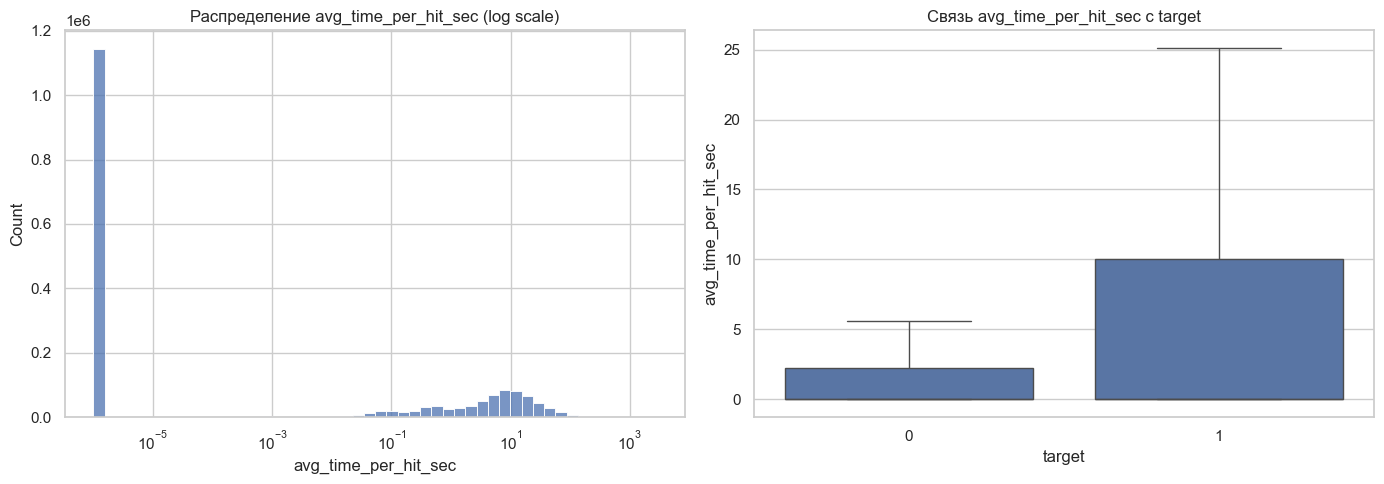

Skipping plot for high cardinality categorical feature 'avg_time_per_hit_sec' (378349 unique values).
Top 5 values:
avg_time_per_hit_sec
0.0000    1144086
0.0010       2612
0.0020        991
0.0800        816
0.0005        811
Name: count, dtype: int64

Statistics for avg_time_per_hit_sec by target:
            mean  median        std  min          max    count
target                                                        
0       6.267070     0.0  35.103519  0.0  2855.976074  1797900
1       8.402536     0.0  24.653076  0.0  1384.543457    62142

Analyzing: is_single_page_session
Skipping plot for high cardinality categorical feature 'is_single_page_session' (2 unique values).
Top 5 values:
is_single_page_session
1    988119
0    871923
Name: count, dtype: int64

Statistics for is_single_page_session by target:
            mean  median       std  min  max    count
target                                               
0       0.541729     1.0  0.498256    0    1  1797900
1       0.2276

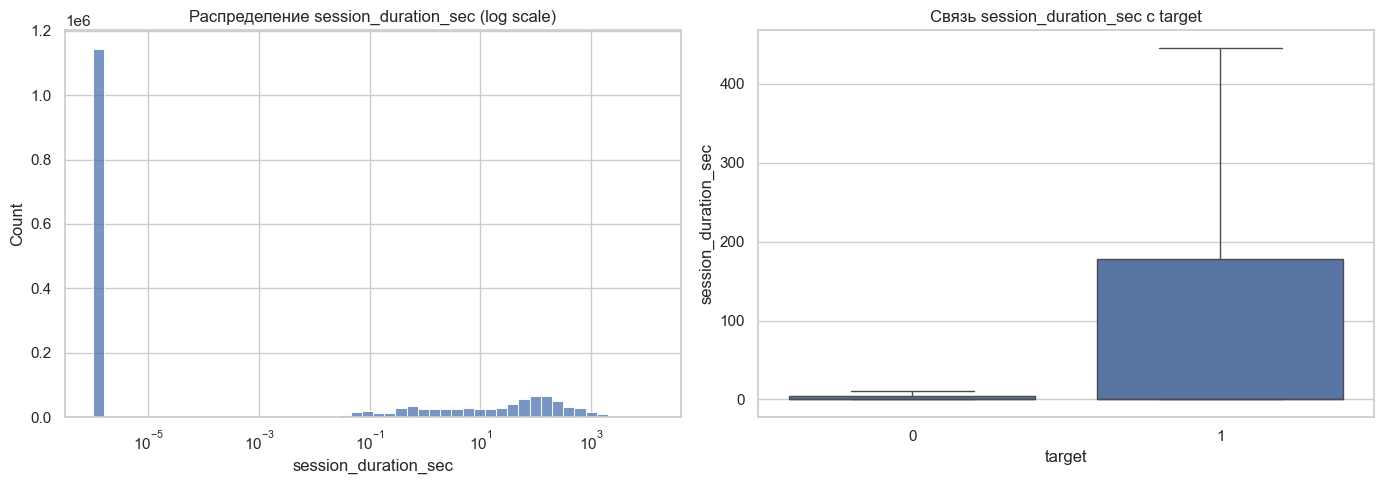

Skipping plot for high cardinality categorical feature 'session_duration_sec' (271441 unique values).
Top 5 values:
session_duration_sec
0.000    1144086
0.001       3209
0.002       1199
0.080        837
0.060        807
Name: count, dtype: int64

Statistics for session_duration_sec by target:
              mean  median         std  min           max    count
target                                                            
0        52.788544     0.0  198.996979  0.0  13156.884766  1797900
1       178.136169     0.0  437.011871  0.0  10571.613281    62142

Analyzing: n_hits


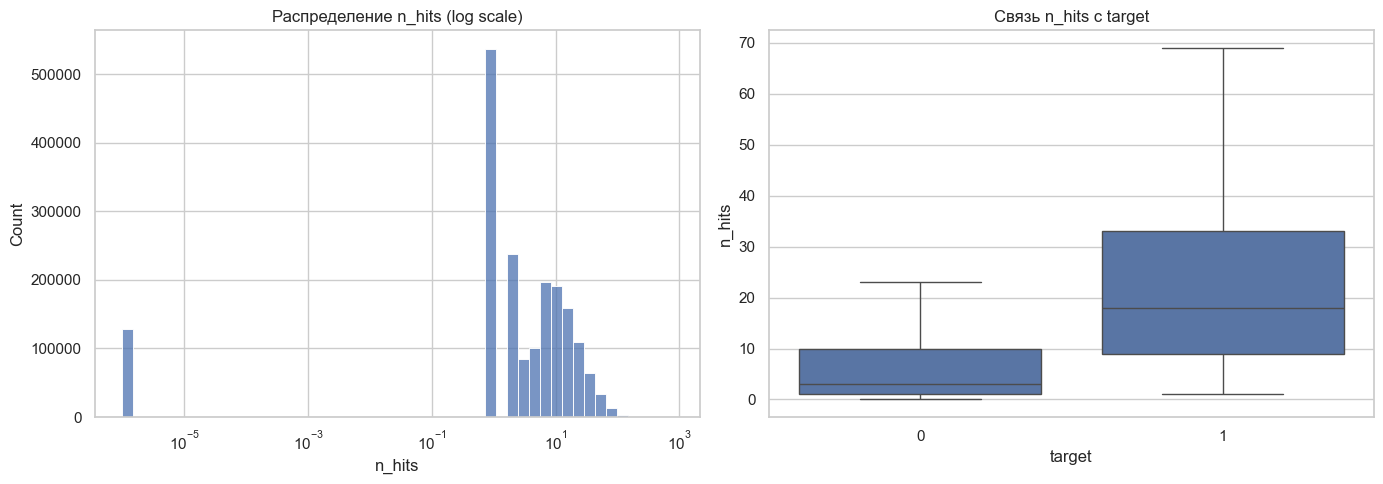

Skipping plot for high cardinality categorical feature 'n_hits' (348 unique values).
Top 5 values:
n_hits
1    536944
2    237402
0    127776
6     87862
3     85150
Name: count, dtype: int64

Statistics for n_hits by target:
             mean  median        std  min  max    count
target                                                 
0        7.854195     3.0  12.598615    0  768  1797900
1       25.170754    18.0  25.361773    1  475    62142

Analyzing: n_unique_pages


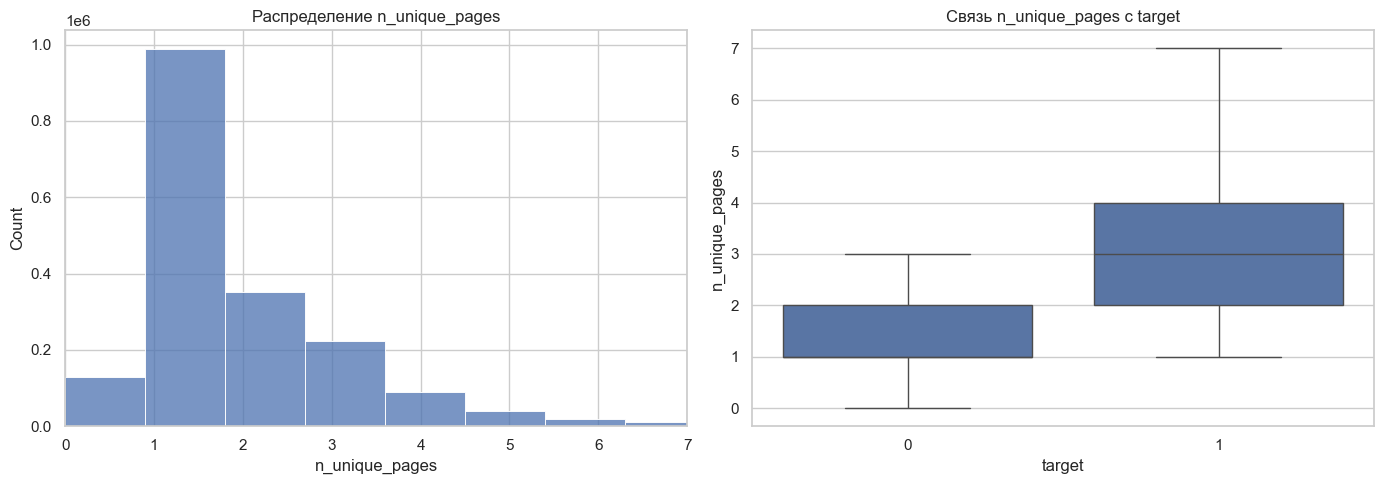

Skipping plot for high cardinality categorical feature 'n_unique_pages' (43 unique values).
Top 5 values:
n_unique_pages
1    988119
2    352485
3    221856
0    127776
4     88036
Name: count, dtype: int64

Statistics for n_unique_pages by target:
            mean  median       std  min  max    count
target                                               
0       1.693587     1.0  1.394186    0   45  1797900
1       2.924286     3.0  1.977590    1   36    62142

Analyzing: visit_number


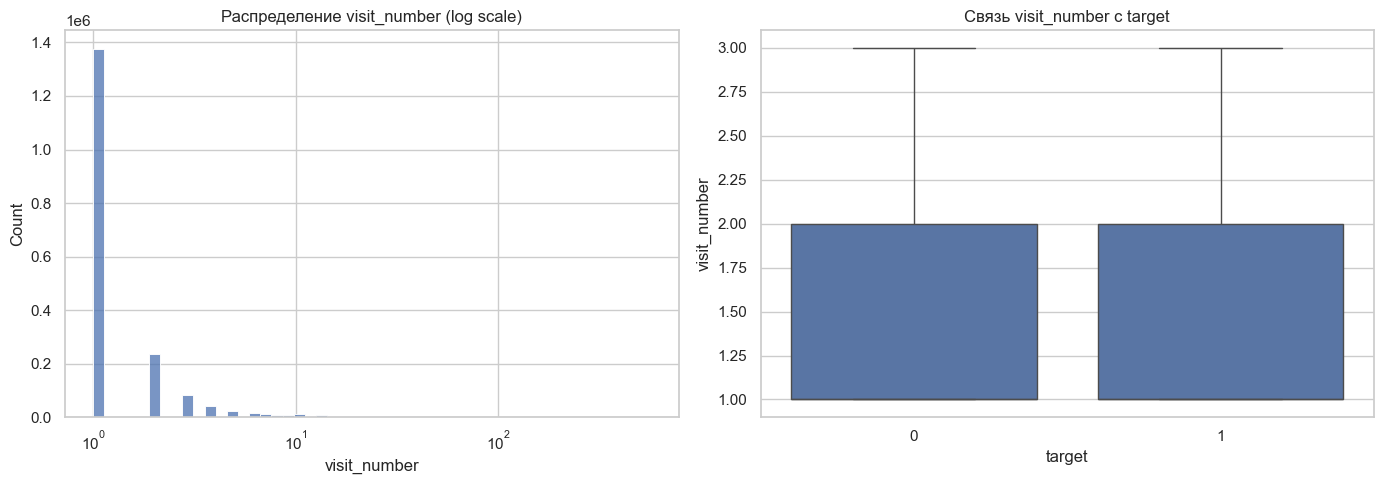

Skipping plot for high cardinality categorical feature 'visit_number' (537 unique values).
Top 5 values:
visit_number
1    1376349
2     235656
3      81068
4      41666
5      24271
Name: count, dtype: int64

Statistics for visit_number by target:
            mean  median        std  min  max    count
target                                                
0       2.662955     1.0  11.223900    1  564  1797900
1       4.155064     1.0  23.268351    1  562    62142

Analyzing: traffic_type
Skipping plot for high cardinality categorical feature 'traffic_type' (3 unique values).
Top 5 values:
traffic_type
paid       1620055
organic     215084
social       24903
Name: count, dtype: int64

Statistics for traffic_type by target:
              Conversion Rate    count
traffic_type                          
organic              0.055053   215084
paid                 0.030649  1620055
social               0.026021    24903

Analyzing: device_category
Skipping plot for high cardinality categoric

In [ ]:
# Список фичей для выборочного анализа
features_to_analyze_final = [
    'is_night_hours',
    'avg_time_per_hit_sec',
    'is_single_page_session',
    'is_short_session_5s',
    'device_os_browser_limited',
    'session_duration_sec',
    'n_hits',
    'n_unique_pages',
    'visit_number',
    'traffic_type',
    'device_category',
]
target_col = 'target'

for feature in features_to_analyze_final:
    if feature in df_featured.columns:
        print(f"\nAnalyzing: {feature}")
        # Пропускаем EDA для фичей с одним уникальным значением (кроме target)
        if df_featured[feature].nunique() <= 1 and feature != target_col:
             print(f"Skipping EDA for '{feature}' (constant or near-constant value).")
             continue

        if pd.api.types.is_numeric_dtype(df_featured[feature]) and df_featured[feature].nunique() > 2: # Числовые
            plt.figure(figsize=(14, 5))
            plt.subplot(1, 2, 1)
            # Используем log-шкалу для сильно скошенных распределений (например, длительность, хиты)
            use_log_scale = feature in ['session_duration_sec', 'n_hits', 'avg_time_per_hit_sec', 'visit_number']
            plot_data_hist = df_featured[feature].replace(0, 1e-6) if use_log_scale else df_featured[feature] # Заменяем 0 для логарифма
            sns.histplot(plot_data_hist, bins=50, kde=False, log_scale=use_log_scale)
            plt.title(f'Распределение {feature}' + (' (log scale)' if use_log_scale else ''))
            # Ограничиваем выбросы для гистограммы (если не лог-шкала)
            if not use_log_scale:
                 q_low, q_high = df_featured[feature].quantile([0.01, 0.99])
                 if pd.notna(q_low) and pd.notna(q_high) and q_high > q_low: plt.xlim(q_low, q_high)

            if target_col in df_featured.columns:
                plt.subplot(1, 2, 2)
                sns.boxplot(x=target_col, y=feature, data=df_featured, showfliers=False) # Убираем выбросы для boxplot
                plt.title(f'Связь {feature} с {target_col}')
                # plt.ylim(df_featured[feature].quantile(0.01), df_featured[feature].quantile(0.99)) # Можно вернуть ограничение
            plt.tight_layout()
            plt.show()

        print(f"Skipping plot for high cardinality categorical feature '{feature}' ({df_featured[feature].nunique()} unique values).")
        print("Top 5 values:")
        print(df_featured[feature].value_counts().head())

        # Статистика по таргету
        if target_col in df_featured.columns:
             print(f"\nStatistics for {feature} by target:")
             try:
                 if pd.api.types.is_numeric_dtype(df_featured[feature]):
                      # Добавляем медиану к describe
                      print(df_featured.groupby(target_col)[feature].agg(['mean', 'median', 'std', 'min', 'max', 'count']))
                 else:
                      print(df_featured.groupby(feature, observed=True)[target_col].agg(['mean', 'count']).rename(columns={'mean':'Conversion Rate'}))
             except Exception as e:
                  print(f"Could not calculate statistics for {feature}: {e}")

    else:
        print(f"Feature '{feature}' not found in DataFrame.")

### **Выводы по EDA с учетом новых фичей.**

1.  **`visit_number` (Номер визита).**
    *   **Распределение:** подавляющее большинство визитов - первые (`1.37 млн`).
    *   **Конверсия:** пользователи, совершившие целевое действие (`target=1`), в среднем имеют **больший номер визита** (среднее 4.16 против 2.66 у `target=0`). Медиана остается 1 для обеих групп, но это говорит о том, что **повторные визиты более склонны к конверсии**, хотя и составляют меньшую долю трафика.

2.  **`traffic_type` (Тип трафика).**
    *   **Распределение:** платный трафик (`paid`) доминирует по объему (`1.62 млн`), за ним идет органический (`organic`, `0.21 млн`), социальный (`social`) имеет малую долю (`0.02 млн`).
    *   **Конверсия:** **органический трафик (`organic`) показывает наивысшую конверсию (CR 5.5%)**, значительно опережая платный (`paid`, 3.1%) и социальный (`social`, 2.6%).
    *   **Вывод:** органический поиск приводит самую целевую аудиторию. Эффективность платного трафика требует улучшения. Соцсети неэффективны.

3.  **`device_category` (Тип устройства).**
    *   **Распределение:** мобильные устройства (`mobile`) преобладают (`1.47 млн`) над десктопами (`desktop`, `0.37 млн`). Планшеты (`tablet`) редки (`0.02 млн`).
    *   **Конверсия:** **десктоп (`desktop`) конвертируется лучше (CR 3.8%)**, чем мобильные (`mobile`, 3.2%) и планшеты (`tablet`, 2.8%).
    *   **Вывод:** несмотря на больший объем мобильного трафика, пользователи десктопов более склонны к совершению целевого действия.

4.  **`n_unique_pages` (Кол-во уникальных страниц).**
    *   **Распределение:** много сессий с 1 (`0.99 млн`) или 2-3 страницами. Есть сессии с 0 страниц (вероятно, только события без просмотров страниц).
    *   **Конверсия:** конвертирующиеся сессии (`target=1`) имеют **значительно большее среднее количество уникальных страниц** (среднее 2.92 против 1.69 у `target=0`). Медиана также выше (3 против 1).
    *   **Вывод:** **просмотр нескольких страниц - сильный индикатор интереса и потенциальной конверсии.**

5.  **`n_hits` (Количество хитов/событий).**
    *   **Распределение:** много сессий с малым количеством хитов (1, 2, 0).
    *   **Конверсия:** конвертирующиеся сессии (`target=1`) имеют **значительно большее среднее количество хитов** (среднее 25.2 против 7.9 у `target=0`). Медиана также сильно различается (18 против 3).
    *   **Вывод:** **активность пользователя на сайте (количество действий) сильно коррелирует с вероятностью конверсии.**

6.  **`session_duration_sec` (Длительность сессии).**
    *   **Распределение:** очень много сессий с нулевой длительностью (1.14 млн), что может указывать на быстрые отказы или особенности измерения.
    *   **Конверсия:** конвертирующиеся сессии (`target=1`) в среднем **значительно длиннее** (среднее 178 сек против 53 сек у `target=0`). Медиана, однако, равна 0 для обеих групп из-за большого числа нулевых значений.
    *   **Вывод:** **более длительные сессии чаще приводят к конверсии**, но нужно учитывать большое количество очень коротких сессий.

7.  **`avg_time_per_hit_sec` (Среднее время на хит).**
    *   **Распределение:** аналогично длительности, много нулевых значений.
    *   **Конверсия:** конвертирующиеся сессии (`target=1`) имеют **немного большее среднее время на хит** (среднее 8.4 сек против 6.3 сек у `target=0`). Медианы снова нулевые.
    *   **Вывод:** небольшая тенденция к тому, что пользователи, тратящие чуть больше времени между действиями, конвертируются чаще, но эффект менее выражен, чем у общей длительности или числа хитов.

8.  **`is_single_page_session` (Сессия с <=1 уник. страницей).**
    *   **Распределение:** примерно половина сессий (53%).
    *   **Конверсия:** сессии с одной страницей (`value=1`) **значительно реже конвертируются**. Доля таких сессий среди неконвертирующихся (`target=0`) составляет 54.2%, а среди конвертирующихся (`target=1`) - всего 22.8%.
    *   **Вывод:** **это очень сильный негативный предиктор конверсии.**

9.  **`is_short_session_5s` (Сессия короче 5 секунд).**
    *   **Распределение:** большинство сессий (68%) очень короткие.
    *   **Конверсия:** короткие сессии (`value=1`) **реже конвертируются**. Доля коротких сессий среди неконвертирующихся (`target=0`) составляет 68.2%, а среди конвертирующихся (`target=1`) - 61.6%.
    *   **Вывод:** **это также важный негативный предиктор конверсии**, хотя разделяющая способность чуть ниже, чем у `is_single_page_session`.

10. **`is_night_hours` (Ночные часы 0-7).**
    *   **Распределение:** меньшая доля трафика ночью (~17%).
    *   **Конверсия:** ночные сессии (`value=1`) **конвертируются немного реже**. Доля ночных сессий среди неконвертирующихся (`target=0`) - 17.3%, среди конвертирующихся (`target=1`) - 15.4%.
    *   **Вывод:** небольшой негативный эффект ночного времени на конверсию.

**Итоги для фиче-инжиниринга.**

*   **Подтверждена важность фичей вовлеченности:** `n_unique_pages`, `n_hits`, `session_duration_sec`, `is_single_page_session`, `is_short_session_5s`, `avg_time_per_hit_sec`. Их обязательно нужно включать в модель.
*   **Подтверждена важность каналов/устройств:** `traffic_type`, `device_category`, `utm_*_limited`, `device_*_limited`.
*   **Временные фичи:** `visit_number` и `is_night_hours` показывают некоторую связь с таргетом и могут быть полезны. `visit_hour`, `visit_dayofweek`, `visit_month`, `is_weekend` также стоит оставить для модели.

In [ ]:
features_to_limit = {
    'geo_city': 100, 'utm_campaign': 50, 'utm_source': 50,
    'utm_adcontent': 50, 'device_brand': 30,
    'device_os_browser_limited': 30
}
# Используем df_featured как вход для этого шага
df_processed = df_featured.copy()
original_cols_to_drop_after_limit = []

for feature, top_n in features_to_limit.items():
    if feature in df_processed.columns:
        if df_processed[feature].nunique() > top_n:
            print(f"Limiting '{feature}' to Top {top_n} + 'Other'")
            top_categories = df_processed[feature].astype(str).value_counts().nlargest(top_n).index
            new_col_name = f"{feature}_limited"
            df_processed[new_col_name] = df_processed[feature].apply(lambda x: x if str(x) in top_categories else f'Other_{feature}')
            df_processed[new_col_name] = df_processed[new_col_name].astype('category')
            original_cols_to_drop_after_limit.append(feature)
        else:
            new_col_name = f"{feature}_limited"
            df_processed.rename(columns={feature: new_col_name}, inplace=True)
            print(f"Feature '{feature}' has <= {top_n} categories. Renamed to '{new_col_name}'.")
    else:
        print(f"Feature '{feature}' not found, skipping limiting.")

if original_cols_to_drop_after_limit:
    print(f"\nRemoving original columns replaced by '_limited' versions: {original_cols_to_drop_after_limit}")
    df_processed = df_processed.drop(columns=original_cols_to_drop_after_limit, errors='ignore')

all_cols = df_processed.columns.tolist()

Limiting 'geo_city' to Top 100 + 'Other'
Limiting 'utm_campaign' to Top 50 + 'Other'
Limiting 'utm_source' to Top 50 + 'Other'
Limiting 'utm_adcontent' to Top 50 + 'Other'
Limiting 'device_brand' to Top 30 + 'Other'
Feature 'device_os_browser_limited' not found, skipping limiting.

Removing original columns replaced by '_limited' versions: ['geo_city', 'utm_campaign', 'utm_source', 'utm_adcontent', 'device_brand']


In [ ]:
all_cols = df_processed.columns.tolist()

# Колонки для удаления
cols_to_drop = [
    'session_id', 'client_id', 'visit_datetime', 'device_screen_resolution',
    'is_work_hours', 'screen_width', 'screen_height', 'screen_area',
    'pageviews_per_hit_ratio', 'n_pageviews', 'geo_device_cat',
    'utm_keyword', 'device_model', 'geo_country',
    # Исходные колонки, замененные на _limited (если они еще есть)
    'geo_city', 'utm_campaign', 'utm_source', 'utm_adcontent', 'device_brand', 'device_os_browser'
]
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]

In [ ]:
target_col = 'target'
if target_col not in df_processed.columns: raise ValueError(f"Target column '{target_col}' not found!")

In [ ]:
potential_features = [col for col in all_cols if col not in cols_to_drop and col != target_col]

In [ ]:
numeric_features = df_processed[potential_features].select_dtypes(include=np.number).columns.tolist()
categorical_features = df_processed[potential_features].select_dtypes(include=['category', 'object']).columns.tolist()

In [ ]:
print(f"Target column: {target_col}")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Total features for model: {len(potential_features)}")

Target column: target
Numeric features (12): ['visit_number', 'visit_hour', 'visit_dayofweek', 'visit_month', 'is_weekend', 'is_night_hours', 'n_hits', 'n_unique_pages', 'session_duration_sec', 'avg_time_per_hit_sec', 'is_single_page_session', 'is_short_session_5s']
Categorical features (10): ['utm_medium', 'device_category', 'device_os', 'device_browser', 'traffic_type', 'geo_city_limited', 'utm_campaign_limited', 'utm_source_limited', 'utm_adcontent_limited', 'device_brand_limited']
Total features for model: 22


In [ ]:
# Создаем финальный датафрейм X и вектор y
X = df_processed[potential_features].copy()
y = df_processed[target_col].copy()

In [ ]:
print(f"\nShape of final X: {X.shape}")
print(f"Shape of final y: {y.shape}")
print("\nMissing values in final X (should be handled by Imputer):")
missing_X = X.isnull().sum(); print(missing_X[missing_X > 0])


Shape of final X: (1860042, 22)
Shape of final y: (1860042,)

Missing values in final X (should be handled by Imputer):
Series([], dtype: int64)


## 4. Построение и оценка ML-моделей

In [ ]:
preprocessor_config = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

In [ ]:
# Конфигурация моделей и обучения (можно оставить как в прошлый раз)
model_config = {
    'test_size': 0.25,
    'random_state': 42,
    'models_dir': '../models',
    'preprocessor_filename': 'preprocessor_final.joblib',
    'model_filename': 'model_final.joblib',
    'optuna_cv_folds': 3,
    'optuna_n_trials': 5,
    'catboost_iterations': 1000,
    'catboost_early_stopping': 50,
}

In [ ]:
# Создаем папку для моделей
os.makedirs(model_config['models_dir'], exist_ok=True)

--- Starting Training Pipeline ---
Splitting data...
Fitting OHE preprocessor...
OHE preprocessor fitted in 4.94 seconds.

Running Optuna for LightGBM...
Optuna Trial 0 finished. Mean ROC-AUC: 0.87964
Optuna Trial 1 finished. Mean ROC-AUC: 0.87991
Optuna Trial 2 finished. Mean ROC-AUC: 0.88226
Optuna Trial 3 finished. Mean ROC-AUC: 0.87820
Optuna Trial 4 finished. Mean ROC-AUC: 0.88275
Optuna finished 5 trials in 238.39 seconds.
Best LGBM params found (ROC-AUC=0.88275): {'scale_pos_weight': 22.87809627873991, 'n_estimators': 900, 'learning_rate': 0.03223398177428573, 'num_leaves': 93, 'max_depth': 10, 'reg_alpha': 0.07427790011429376, 'reg_lambda': 0.0028265224170662615, 'colsample_bytree': 0.8387441997773086, 'subsample': 0.7135688359966231}

Calculated scale_pos_weight for CatBoost: 28.93

--- Training and Evaluating: Dummy ---
Training Time: 0.16 seconds
Test ROC-AUC: 0.5010, Test PR-AUC: 0.0514
Test F1 (0): 0.9666, Test F1 (1): 0.0353

--- Training and Evaluating: LogisticRegressio

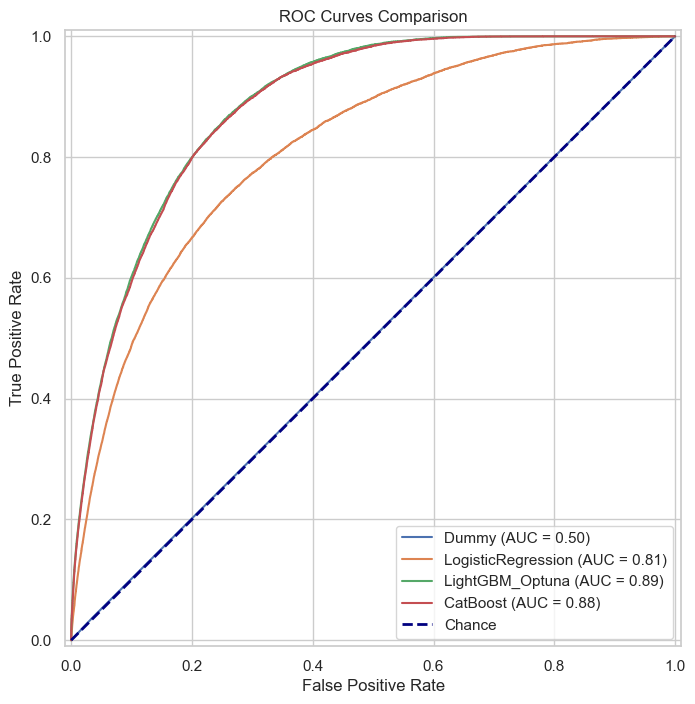

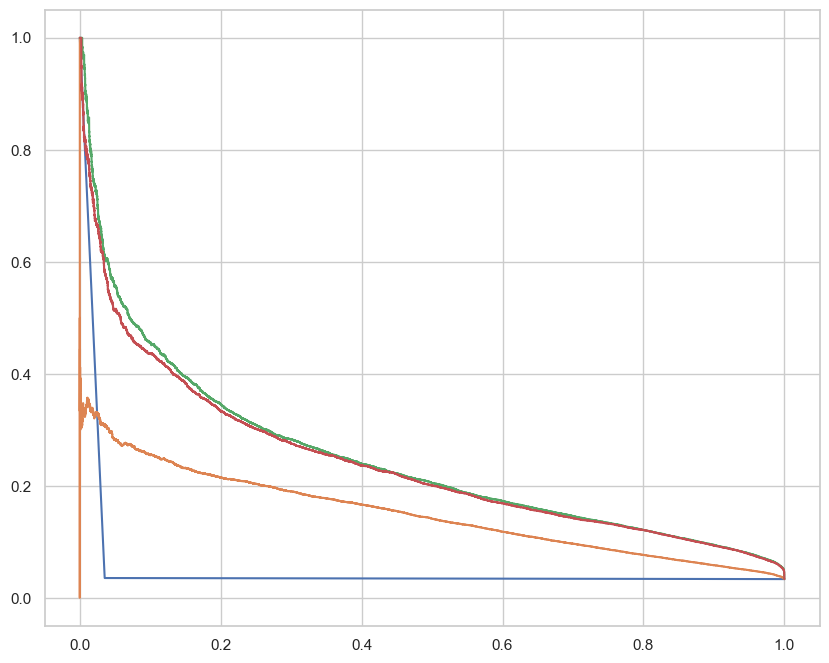


--- Model Comparison (Test Set Metrics) ---
                    ROC-AUC  PR-AUC  F1-score (0)  F1-score (1)  Accuracy
LightGBM_Optuna      0.8862  0.2471        0.8883        0.2131    0.8044
CatBoost             0.8843  0.2392        0.8564        0.1893    0.7560
LogisticRegression   0.8141  0.1501        0.8728        0.1726    0.7794
Dummy                0.5010  0.0514        0.9666        0.0353    0.9355

Best model (excluding Dummy) based on ROC-AUC: LightGBM_Optuna
Selected OHE-compatible model for saving: LightGBM_Optuna
Saving OHE preprocessor to ../models\preprocessor_final.joblib
Saving trained LightGBM_Optuna model to ../models\model_final.joblib

--- Training Pipeline Finished in 860.84 seconds ---


In [ ]:
# Запускаем пайплайн обучения и оценки
results_df, feature_importances, trained_models = tr.run_training_pipeline(
    X, y, model_config, preprocessor_config
)

In [ ]:
feature_importances

{'Dummy': None,
 'LogisticRegression':                                           feature  importance
 0                cat__geo_city_limited_Prineville   -4.952086
 1                     cat__geo_city_limited_Lulea   -4.546815
 2               cat__geo_city_limited_Forest City   -4.434583
 3                    cat__geo_city_limited_Dublin   -3.978710
 4    cat__utm_source_limited_fgymSoTvjKPEgaIJqsiH   -3.720339
 ..                                            ...         ...
 419                  cat__device_browser_Nokia501   -0.001312
 420  cat__device_browser_Instagram 199.0.0.27.120   -0.001310
 421  cat__device_browser_Instagram 203.0.0.26.117   -0.001310
 422                          num__visit_dayofweek   -0.000749
 423                cat__device_browser_NokiaX2-02   -0.000528
 
 [424 rows x 2 columns],
 'LightGBM_Optuna':                         feature  importance
 0                   num__n_hits       12455
 1               num__visit_hour        7199
 2     num__session_durat

# **Финальные выводы по работе.**

1.  **Модель:** в ходе проекта была разработана и оценена модель `LightGBM` (с параметрами, подобранными с помощью Optuna) для предсказания вероятности совершения пользователем целевого действия (конверсия ~3.34%) на сайте «СберАвтоподписка». Финальные метрики на тестовой выборке: **ROC-AUC = 0.8862**, **PR-AUC = 0.2471**. Модель значительно превосходит baseline (Dummy ROC-AUC=0.5010, PR-AUC=0.0514) и целевой порог ROC-AUC 0.65. F1-score для целевого класса (1) составил 0.2131, что отражает сложность предсказания редкого события, но показывает способность модели идентифицировать конверсионные сессии лучше случайного угадывания. Сохранены препроцессор (`preprocessor_final.joblib`) и обученная модель `LightGBM_Optuna` (`model_final.joblib`) для дальнейшего использования.

2.  **Ключевые факторы конверсии:** анализ важности признаков для лучшей модели (LightGBM) показал, что наибольшее влияние на вероятность конверсии оказывают:
    *   **поведенческие факторы:** количество хитов (`n_hits`), длительность сессии (`session_duration_sec`), среднее время между хитами (`avg_time_per_hit_sec`), номер визита (`visit_number`), флаг сессии с одной страницей (`is_single_page_session` - негативное влияние).
    *   **временные факторы:** час визита (`visit_hour`).
    *   **источник трафика:** `utm_source_limited` (ограниченная версия источника).
    *   **другие:** месяц визита (`visit_month`), операционная система (`device_os`).
    Это подтверждает выводы EDA о критической важности пользовательской вовлеченности и качества источника трафика.

3.  **Рекомендации для бизнеса:**
    *   **оптимизация каналов:** сосредоточиться на привлечении трафика из каналов и источников, показавших высокую конверсию в EDA (`organic`, `referral`) и/или имеющих высокую важность в модели (`utm_source_limited`). Провести аудит и оптимизацию платных кампаний, особенно тех, что не попали в топ по важности или имели низкий CR. Улучшить разметку трафика для уменьшения доли `unknown`.
    *   **улучшение UX и вовлеченности:** снизить показатель отказов, обратив особое внимание на сессии с одним хитом/страницей и короткие сессии. Улучшить контент и навигацию на первых экранах, чтобы стимулировать дальнейшее взаимодействие. Проанализировать и оптимизировать пользовательский путь для платформ с низкой конверсией (Mobile, iOS/Safari).
    *   **использование модели:**
        *   оценивать эффективность новых рекламных каналов/кампаний по предсказанной вероятности конверсии.
        *   приоритизировать обработку лидов или запускать таргетированные действия (ремаркетинг, чат, спецпредложения) для пользователей с высокой предсказанной вероятностью конверсии.
        *   выявлять сегменты с аномально низкой вероятностью конверсии для анализа причин.
    *   **дальнейшие шаги:** провести A/B тесты на основе рекомендаций, использовать SHAP для более глубокой интерпретации модели, настроить регулярное переобучение.